# Implementing Neural Networks to predict life expectancy

The World Health Organization (WHO)’s Global Health Observatory (GHO) data repository tracks life expectancy for countries worldwide by following health status and many other related factors.

Although there have been a lot of studies undertaken in the past on factors affecting life expectancy considering demographic variables, income composition, and mortality rates, it was found that the effects of immunization and human development index were not taken into account.

This [Kaggle dataset](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who) covers a variety of indicators for all countries from 2000 to 2015 including:
- immunization factors
- mortality factors
- economic factors
- social factors
- other health-related factors

Ideally, this data will eventually inform countries concerning which factors to change in order to improve the life expectancy of their populations. If we can predict life expectancy well given all the factors, this is a good sign that there are some important patterns in the data. Since life expectancy is expressed in years, I will use regression in my predictive model.

**Objective:** in this project I will design, train and evaluate a neural network model performing the task of regression to predict the life expectancy of countries using this dataset.

## Quick data exploration and cleaning

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#import data
data = pd.read_csv('/kaggle/input/life-expectancy-who/Life Expectancy Data.csv')
print(data.shape)
data.head()

(2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
data.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,...,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,...,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,...,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,...,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,...,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,...,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [5]:
#check column names and clean them
data.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [6]:
data.rename(columns = lambda x: x.strip(), inplace=True)
data.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [7]:
#drop Country column as we want a model that can generalize and this column can be confusing
data.drop(columns=['Country'], inplace=True)

#drop rows that contains null values in column Life expectancy
data.dropna(axis=0, subset=['Life expectancy'], inplace=True)
data.shape

(2928, 21)

In [8]:
#one hot encoding of Status column
#make sure there are no missing values first
print('Missing values in Status column:',  data.Status.isnull().sum())

#one hot encoding
data = pd.get_dummies(data)*1   # *1 to make booleans into numbers
data.head()

Missing values in Status column: 0


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,1
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,0,1
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,0,1


In [9]:
#create X and y
y = data['Life expectancy']
X = data.drop(columns=['Life expectancy'])

## Data preprocessing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [11]:
#define catergorical and numerical columns
#cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

#create separate pipelines for the two groups of columns
#cat_vals = Pipeline([("imputer",SimpleImputer(strategy='most_frequent')), 
                     #("ohe",OneHotEncoder())])
num_vals = Pipeline([("imputer",SimpleImputer(strategy='mean')), 
                     ("scale",StandardScaler())])

#apply preprocessing
preprocess = ColumnTransformer(
    transformers=[("num_process", num_vals, num_cols)])

x_train_processed = preprocess.fit_transform(x_train)
x_test_processed = preprocess.transform(x_test)

In [12]:
x_train_processed = pd.DataFrame(x_train_processed, columns = x_train.columns)
x_test_processed = pd.DataFrame(x_test_processed, columns = x_test.columns)

# Build the model

In [13]:
input_shape = x_train_processed.shape[1]

model = keras.Sequential([
    layers.Dense(32, input_shape=(input_shape,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),   
    layers.Dense(1)
])

model.compile(
        optimizer='adam',
        loss='mae'
)

early_stopping = EarlyStopping(
        min_delta=0.01,
        patience=20,
        restore_best_weights=True
)

history = model.fit(
    x_train_processed, y_train,
    validation_data=(x_test_processed, y_test),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, 
)


Minimum validation loss: 2.016127824783325


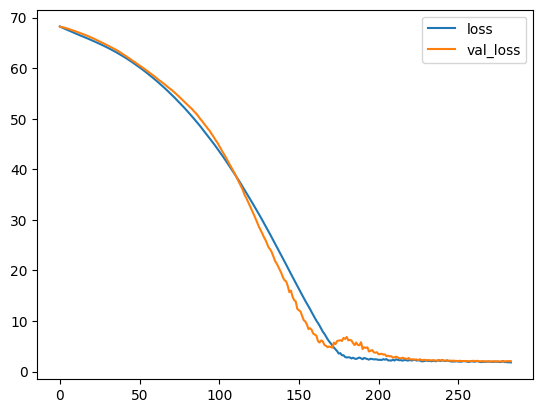

In [14]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot()

print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [15]:
#make a 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x_train_processed, y_train)
y_pred = dummy_regr.predict(x_test_processed)
MAE_baseline = mean_absolute_error(y_test, y_pred)
print(MAE_baseline)

7.6571769993267305


## Conclusions

The model performs quite well, especially compared to the dummy regrssor. However, the model might be overfitting the data, looking at the behaviour of the two curves in the graph. Adding Dropout layers to the model could help. Furthermore, to improve the model hyperparameter tuning could be performed. 